## Imports and Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data_cleaned.csv')

## Data Exploration

In [3]:
data.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,1778,SI,2019-07-31,101.0,0.56,6.14,606466.0,547973.0,force_out,hit_into_play,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1,1839,SL,2019-07-31,88.1,0.55,6.24,606466.0,547973.0,NaN,foul,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
2,1867,SL,2019-07-31,85.8,0.39,6.13,606466.0,547973.0,NaN,swinging_strike,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
3,1932,FF,2019-07-31,96.5,0.72,6.13,572233.0,547973.0,walk,ball,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
4,1956,FF,2019-07-31,96.8,0.50,6.16,572233.0,547973.0,NaN,ball,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110615 entries, 0 to 110614
Data columns (total 63 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  110615 non-null  int64  
 1   pitch_type             110314 non-null  object 
 2   game_date              110615 non-null  object 
 3   release_speed          110327 non-null  float64
 4   release_pos_x          110323 non-null  float64
 5   release_pos_z          110323 non-null  float64
 6   batter                 110615 non-null  float64
 7   pitcher                110615 non-null  float64
 8   events                 28216 non-null   object 
 9   description            110615 non-null  object 
 10  zone                   110323 non-null  float64
 11  stand                  110615 non-null  object 
 12  p_throws               110615 non-null  object 
 13  type                   110615 non-null  object 
 14  hit_location           24620 non-nul

How many at-bats are there per game? How many pitches per at-bat?

In [5]:
data.groupby('game_pk')['at_bat_number'].agg(max).mean()

77.42896174863388

In [6]:
data.groupby(['game_pk', 'at_bat_number'])['pitch_number'].agg(max).mean()

3.9148823217129713

In [7]:
data.groupby(['game_pk', 'at_bat_number'])['pitch_number'].agg(max)

game_pk   at_bat_number
564777.0  1.0              4.0
          2.0              4.0
          3.0              4.0
          4.0              7.0
          5.0              1.0
                          ... 
567608.0  70.0             3.0
          71.0             5.0
          72.0             4.0
          73.0             3.0
          74.0             4.0
Name: pitch_number, Length: 28255, dtype: float64

Descriptive statistics for float64 type features:

In [8]:
floats = data.select_dtypes('float64')
for i in floats:
    print(floats[i].describe(),'\n')

count    110327.000000
mean         88.742331
std           5.966305
min          50.800000
25%          84.500000
50%          90.000000
75%          93.500000
max         102.300000
Name: release_speed, dtype: float64 

count    110323.000000
mean         -0.726779
std           1.948320
min          -5.380000
25%          -2.130000
50%          -1.490000
75%           1.290000
max           4.650000
Name: release_pos_x, dtype: float64 

count    110323.00000
mean          5.89709
std           0.49793
min           0.59000
25%           5.63000
50%           5.92000
75%           6.23000
max           7.35000
Name: release_pos_z, dtype: float64 

count    110615.000000
mean     573018.066998
std       67183.160782
min      405395.000000
25%      519390.000000
50%      592680.000000
75%      623993.000000
max      670970.000000
Name: batter, dtype: float64 

count    110615.000000
mean     572594.659793
std       67262.753649
min      282332.000000
25%      519443.000000
50%      592

In [9]:
objects = data.select_dtypes('object')
for i in objects:
    print(objects[i].value_counts(),'\n')

FF    40020
SL    19666
CH    12350
FT     9638
CU     9160
SI     8181
FC     7153
KC     2586
FS     1480
KN       50
FO       25
EP        5
Name: pitch_type, dtype: int64 

2019-07-13    5088
2019-07-23    4833
2019-07-03    4766
2019-07-24    4622
2019-07-30    4598
2019-07-21    4596
2019-07-19    4581
2019-07-28    4554
2019-07-14    4519
2019-07-27    4501
2019-07-20    4471
2019-07-07    4457
2019-07-16    4423
2019-07-06    4374
2019-07-12    4359
2019-07-26    4287
2019-07-02    4280
2019-07-17    4212
2019-07-31    4115
2019-07-05    4002
2019-07-18    3996
2019-07-04    3677
2019-07-15    3360
2019-07-25    3137
2019-07-22    3007
2019-07-29    2050
2019-07-01    1477
2019-07-11     273
Name: game_date, dtype: int64 

field_out                       10907
strikeout                        6522
single                           3999
walk                             2183
double                           1363
home_run                         1057
force_out                      

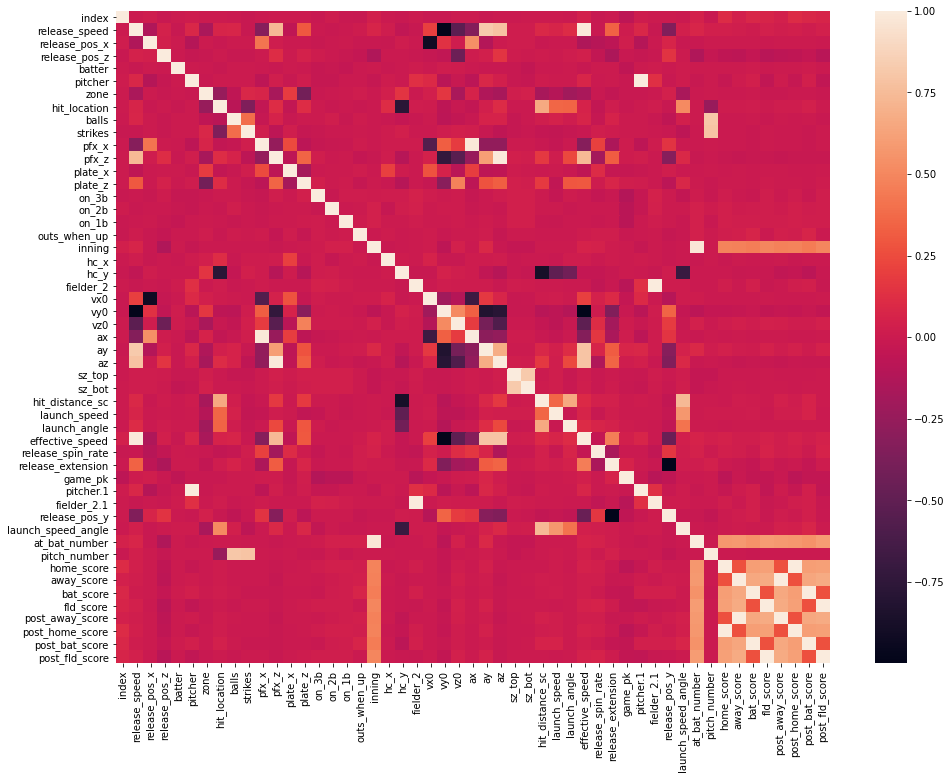

In [10]:
plt.subplots(figsize=(16,12))
sns.heatmap(data.corr());

In [11]:
basics = data[['pitch_type', 'balls', 'strikes', 'outs_when_up', 'inning', 'game_pk', 'at_bat_number', 'pitch_number']]

In [12]:
basics.head()

,pitch_type,balls,strikes,outs_when_up,inning,game_pk,at_bat_number,pitch_number
0,SI,0.0,2.0,2.0,9.0,567514.0,77.0,3.0
1,SL,0.0,1.0,2.0,9.0,567514.0,77.0,2.0
2,SL,0.0,0.0,2.0,9.0,567514.0,77.0,1.0
3,FF,3.0,0.0,2.0,9.0,567514.0,76.0,4.0
4,FF,2.0,0.0,2.0,9.0,567514.0,76.0,3.0


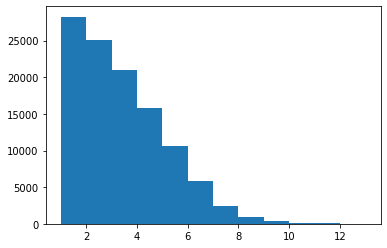

In [13]:
_ = plt.hist(data['pitch_number'], bins = 12)

In [15]:
list(data)

['index',
 'pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'batter',
 'pitcher',
 'events',
 'description',
 'zone',
 'stand',
 'p_throws',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'fielder_2',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'pitcher.1',
 'fielder_2.1',
 'release_pos_y',
 'launch_speed_angle',
 'at_bat_number',
 'pitch_number',
 'pitch_name',
 'home_score',
 'away_score',
 'bat_score',
 'fld_score',
 'post_away_score',
 'post_home_score',
 'post_bat_score',
 'post_fld_score',
 'if_fielding_alignment',
 'of_fielding_alignment']

In [16]:
data['at_bat_id'] = data['game_pk'].astype(str)+'_'+data['at_bat_number'].astype(str)

In [17]:
temp = data[['at_bat_id', 'pitch_type']]

In [18]:
temp['pitch_type'] = temp['pitch_type'].astype(str)

C:\Users\Louie\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
vectors = temp.groupby('at_bat_id', as_index = False)['pitch_type'].agg('sum')

In [20]:
pitch_count = temp.groupby('at_bat_id', as_index = False)['pitch_type'].agg('count')
vectors = vectors.merge(pitch_count, on = 'at_bat_id')

In [21]:
vectors['pitch_type_x'].value_counts()

FF                  1220
FFFF                 652
FFFFFF               448
SL                   431
FT                   378
                    ... 
SLSLFTCHSLFT           1
FSFSFFFFFFFFKC         1
CUFSFFFF               1
SISISISISISISL         1
FFFFCHFFFFCHFFFF       1
Name: pitch_type_x, Length: 8441, dtype: int64